In [ ]:
import torch
import json
import numpy as np
import torchvision
import os
from torchvision import transforms
from pathlib import Path
from scipy.ndimage import gaussian_filter1d, uniform_filter1d
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.size'] = 32

def linear_fit(x, y):
    x_ = x - x.mean()
    y_ = y - y.mean()
    k = (x_ * y_).sum() / (x_ * x_).sum()
    b = y.mean() - k * x.mean()
    return k, b

num_channels = 64

plot_folder = './'
os.makedirs(plot_folder, exist_ok=True)

def download_folder(folder_name):
    triples = []
    data = []
    for p in Path(folder_name).iterdir():
        name = p.name
        if name.startswith("lr"):
            lr = float(name[2:])
            if not os.path.exists(f'{folder_name}/{name}/trace.pt'):
                continue
            f = torch.load(f'{folder_name}/{name}/trace.pt', map_location=torch.device('cpu'))
            tr = f['trace']
            with open(f'{folder_name}/{name}/config.json', 'r') as f:
                cfg = (json.load(f))
            triples.append((lr, tr, cfg))
    triples.sort(key=lambda x: x[0])
    lrs = [x[0] for x in triples]
    trace = [x[1] for x in triples]
    config = [x[2] for x in triples]
    num_params = len(trace[0]['weight'][0])
    return lrs, trace, config, num_params

objs = ["5000", "12500", "25000", "50000"]
ff = [download_folder(f'../../exp-convnet{num_channels}-seed1-cifar10-{obj}obj-ce') for obj in objs]
lrs = [ff[i][0] for i in range(len(objs))]
trace = [ff[i][1] for i in range(len(objs))]
config = [ff[i][2] for i in range(len(objs))]

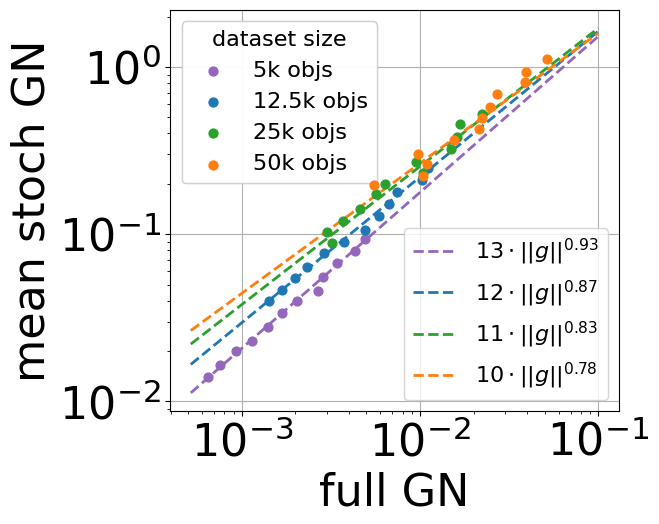

In [2]:
fig, ax = plt.subplots(1, 1, figsize=(7.3, 6))

cmap = [plt.cm.tab10(4), plt.cm.tab10(0), plt.cm.tab10(2), plt.cm.tab10(1)]

i = 0
lr = lrs[0][0]
for j in range(4):
    idd = (np.array(config[j][i]['log_iters']) >= 2e5)[:len(trace[j][i]['full_grad_norm'])]
    grad_norm = np.array(trace[j][i]['full_grad_norm'])[idd]
    stoch_norm = np.array(trace[j][i]['stoch_grad_mean_norm'])[idd]
    label_num = '12.5' if objs[j] == "12500" else (int(objs[j]) // 1000)
    ax.scatter(grad_norm[::3], stoch_norm[::3], zorder=10, s=40,  color=cmap[j], 
               label=f'{label_num}k objs')
    

ax.grid(True)
ax.set_xlabel('full GN')
ax.set_ylabel('mean stoch GN')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_yticks(10. ** np.array([-2, -1, 0]))
ax.set_xticks(10. ** np.array([-3, -2, -1]))
g1, g2 = ax.get_xlim()
for j in range(4):
    idd = (np.array(config[j][i]['log_iters']) >= 2e5)[:len(trace[j][i]['full_grad_norm'])]
    grad_norm = np.array(trace[j][i]['full_grad_norm'])[idd]
    stoch_norm = np.array(trace[j][i]['stoch_grad_mean_norm'])[idd]
    k, b= linear_fit(np.log(grad_norm), np.log(stoch_norm))
    mn = np.array(grad_norm[:]).min()
    mx = np.array(grad_norm[:]).max()
    x = np.logspace(np.log10(g1), np.log10(g2), 100)
    ax.plot(x, np.exp(b) * x ** k, '--', zorder=7, linewidth=2, color=cmap[j], label=f'${{{np.exp(b):.0f}}} \cdot ||g||^{{{k:.2f}}}$')

handles, labels = ax.get_legend_handles_labels()
lines_legend = ax.legend(handles[4:], labels[4:], loc="lower right", fontsize=16)
ax.add_artist(lines_legend)
dataset_legend = ax.legend(handles[:4], labels[:4], loc="upper left", fontsize=16, title='dataset size', title_fontsize=16)
ax.add_artist(dataset_legend)
plt.tight_layout()
plt.savefig(f'{plot_folder}/op_grad_phase_conv.png', dpi=200, bbox_inches='tight')